# Library Installation

In [ ]:
import tensorflow as tf


device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [ ]:
!pip install livelossplot
!pip install keras_applications --no-deps
!pip install -q kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.5 MB/s eta 0:00:00


# Kaggle Connection Setup

In [ ]:
# сюда подгружать файл kaggle.jsonс ключами
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"grigorevaaaaa","key":"526b3bce72bdee94e15af8ddaeba0cdd"}'}

In [ ]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

ref                                                            title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
salvatorerastelli/spotify-and-youtube                          Spotify and Youtube                                   9MB  2023-03-20 15:43:25          11256        394  1.0              
arnabchaki/data-science-salaries-2023                          Data Science Salaries 2023  💸                        25KB  2023-04-13 09:55:16           5367        133  1.0              
erdemtaha/cancer-data                                          Cancer Data                                          49KB  2023-03-22 07:57:00           5680        114  1.0              
evangower/premier-league-2022-2023                             Pr

In [ ]:
!kaggle datasets download -d jangedoo/utkface-new
!mkdir gender_dataset
!unzip utkface-new.zip -d gender_dataset

# Essentials Import

In [ ]:
import numpy as np
import pandas as pd

from tensorflow import keras
from keras.models import model_from_json
from PIL import Image
from livelossplot import PlotLosses

import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

%matplotlib inline

# Preprocessing Dataset

In [ ]:
img_size = (48, 48)

In [ ]:
import os

folder_path = "/content/gender_dataset/UTKFace"
gender = []
img_path = []
for file in os.listdir(folder_path):
    gender.append("female" if file.split('_')[1] == '1' else "male")
    img_path.append(file)

In [ ]:
df2 = pd.DataFrame({'gender': gender, 'img': img_path})
df2.head()

,gender,img
0,male,26_0_2_20170116175433114.jpg.chip.jpg
1,female,26_1_1_20170116231826726.jpg.chip.jpg
2,female,35_1_0_20170116201625242.jpg.chip.jpg
3,female,32_1_1_20170116154724484.jpg.chip.jpg
4,female,21_1_0_20170112233608086.jpg.chip.jpg


In [ ]:
train_df2 = df2.sample(frac=1,random_state=0).iloc[:20000]
test_df2 = df2.sample(frac=1,random_state=0).iloc[20000:]

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(train_df2,
                                                    directory=folder_path,
                                                    x_col='img',
                                                    y_col='gender',
                                                    target_size=img_size,
                                                    batch_size = 64,
                                                    class_mode='binary')

test_generator = test_datagen.flow_from_dataframe(test_df2,
                                                    directory=folder_path,
                                                    x_col='img',
                                                    y_col='gender',
                                                    batch_size = 64,
                                                    target_size=img_size,
                                                    class_mode='binary')

Found 20000 validated image filenames belonging to 2 classes.
Found 3708 validated image filenames belonging to 2 classes.


In [ ]:
train_generator.class_indices

{'female': 0, 'male': 1}

# Model Architecture

In [ ]:
kernel_s = (3,3) # The size of kernel

In [ ]:
from keras import regularizers

model = Sequential()
model.add(Conv2D(32, kernel_s, activation='relu', input_shape=(48, 48, 3),
                        kernel_regularizer=regularizers.l2(0.001),padding="VALID"))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, kernel_s, activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, kernel_s, activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, kernel_s, activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)        

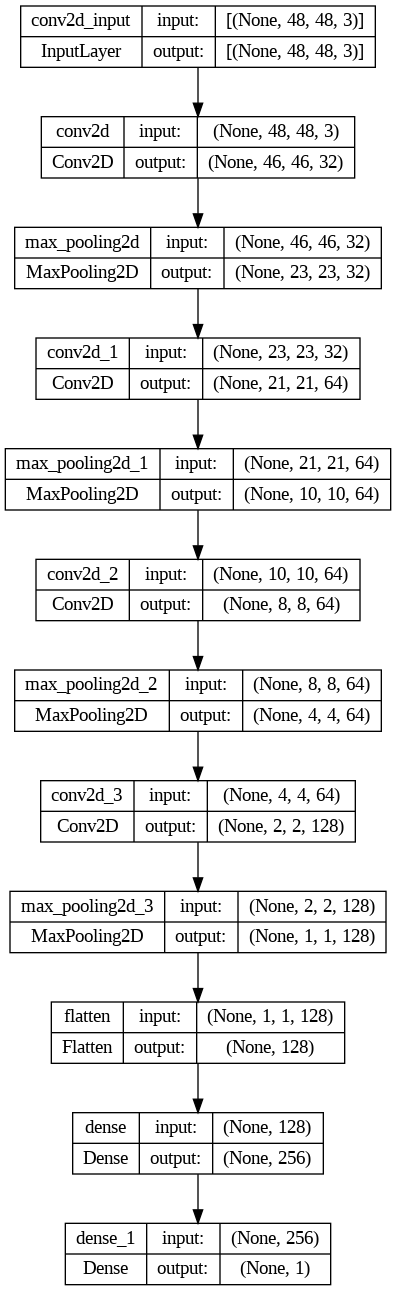

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
]

In [ ]:
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy', 
              metrics=METRICS)

# Model Training

In [ ]:
history = model.fit(train_generator,
                    epochs=30,
                    verbose=1)

Epoch 1/30
313/313 [==============================] - 114s 363ms/step - loss: 0.6357 - accuracy: 0.6375 - precision: 0.6298 - recall: 0.7519 - auc: 0.6908
Epoch 2/30
313/313 [==============================] - 118s 378ms/step - loss: 0.5463 - accuracy: 0.7272 - precision: 0.7319 - recall: 0.7584 - auc: 0.7993
Epoch 3/30
313/313 [==============================] - 107s 341ms/step - loss: 0.4905 - accuracy: 0.7641 - precision: 0.7712 - recall: 0.7832 - auc: 0.8445
Epoch 4/30
313/313 [==============================] - 111s 354ms/step - loss: 0.4577 - accuracy: 0.7878 - precision: 0.7926 - recall: 0.8071 - auc: 0.8673
Epoch 5/30
313/313 [==============================] - 109s 349ms/step - loss: 0.4275 - accuracy: 0.7999 - precision: 0.8067 - recall: 0.8142 - auc: 0.8851
Epoch 6/30
313/313 [==============================] - 107s 340ms/step - loss: 0.4056 - accuracy: 0.8146 - precision: 0.8184 - recall: 0.8316 - auc: 0.8983
Epoch 7/30
313/313 [==============================] - 107s 340ms/step 

In [ ]:
model.save('gender_model_tf_result.h5') 

<Figure size 640x480 with 0 Axes>

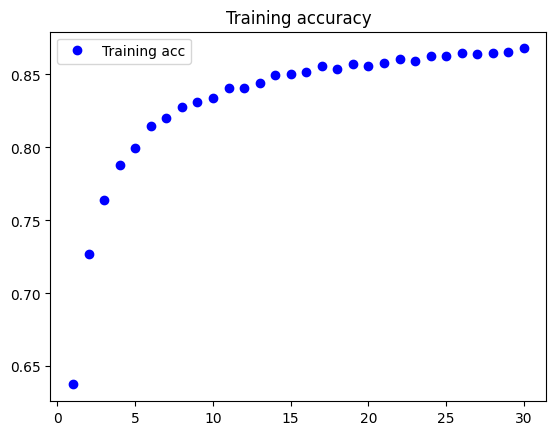

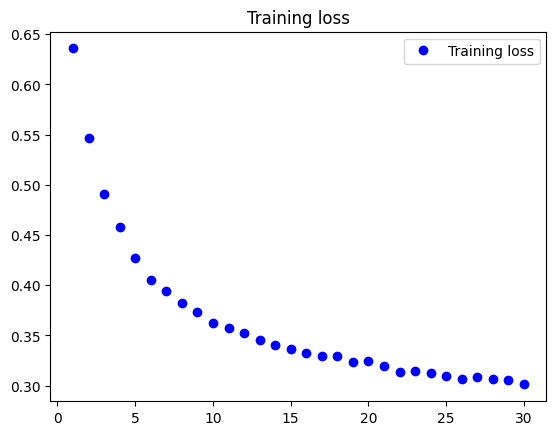

<Figure size 640x480 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.figure()

# Model Testing

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
my_model = tf.keras.models.load_model('/content/gender_model_tf_result.h5')

# Show the model architecture
my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 29, 29, 64)       0

In [ ]:
test_gen = test_datagen.flow_from_directory('/content/test',
                                           target_size=img_size,
                                           batch_size=64,
                                           class_mode='binary')

Found 3 images belonging to 2 classes.


In [ ]:
my_model.predict(test_gen)

1/1 [==============================] - 0s 216ms/step


array([[0.90022695],
       [0.8241549 ],
       [0.7109406 ]], dtype=float32)